In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
# get_ipython().magic(u'matplotlib auto')
import tensorflow as tf
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# import torch
from tensorflow import keras
import statistics

In [2]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Activation, Conv3D, MaxPooling3D
from tensorflow import reshape
from keras.utils import np_utils
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling1D,AveragePooling1D
from tensorflow.keras.layers import Input, LocallyConnected1D
from tensorflow.keras.layers import SeparableConv1D, Bidirectional
from tensorflow.keras.layers import LocallyConnected2D
from tensorflow.keras.layers import ZeroPadding2D,ZeroPadding1D, MaxPooling2D, Bidirectional
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import CSVLogger,LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [3]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
from numpy import std
# import coremltools
# from torch import nn, optim
# import torch.nn.functional as F
import scipy.io
from scipy import stats
#from IPython.display import display, HTML
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU,SimpleRNN
from tensorflow.keras.layers import TimeDistributed
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

In [4]:
# The number of steps within one time segment
TIME_PERIODS = 500
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 500
N_FEATURES = 10

In [5]:
column_names = ['C'+str(j) for j in range(1, N_FEATURES+1)]
lst = ['Class_label']
column_names = column_names+lst
print(column_names)

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'Class_label']


In [6]:
def read_data_Train(file_path_Train):
    df_Train = pd.read_csv(file_path_Train,header=None,names=column_names)
    # Last column has a ";" character which must be removed ...
    df_Train['Class_label'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    # ... and then this column must be transformed to float explicitly
    df_Train['Class_label'] = df_Train['Class_label'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df_Train.dropna(axis=0, how='any', inplace=True)
    return df_Train
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [7]:
def show_basic_dataframe_info(dataframe):
    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

In [8]:
def read_data_Test(file_path_Test):
    df_Test = pd.read_csv(file_path_Test,header=None,names=column_names)
    # Last column has a ";" character which must be removed ...
    df_Test['Class_label'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    # ... and then this column must be transformed to float explicitly
    df_Test['Class_label'] = df_Test['Class_label'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df_Test.dropna(axis=0, how='any', inplace=True)
    return df_Test

In [9]:
 pd.options.display.float_format = "{:,.5f}".format

In [10]:
# 15 function to segment data into trial lengths (trial length =513 samples in this dataset)
def create_segments_and_labels(df, time_steps,step,n_features, label_name):
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
      for j in range(1, n_features+1):
        L = ('C'+str(j)) 
        segments.append(df[str(L)].values[i: i + time_steps])
      label = stats.mode(df[label_name][i: i + time_steps])[0][0]
      labels.append(label)
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, n_features)
    labels = np.asarray(labels)
    return reshaped_segments, labels

In [11]:
# import os
path='/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/Total_process_TT/'

In [12]:
# file_path_train=path+'Train_data'+'.'+'csv'
file_path_train=path+'nina_pro_naveen_DB1_Train'+'.'+'csv'
print(file_path_train)

/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/Total_process_TT/nina_pro_naveen_DB1_Train.csv


In [13]:
file_path_test=path+'nina_pro_naveen_DB1_Test'+'.'+'csv'
# file_path_test=path+'Test_data'+'.'+'csv'
print(file_path_test)

/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/Total_process_TT/nina_pro_naveen_DB1_Test.csv


In [14]:
df_Train=read_data_Train(file_path_train)
show_basic_dataframe_info(df_Train)
df_Train.head(5)

Number of columns in the dataframe: 11
Number of rows in the dataframe: 4914000



,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label
0,0.00720,0.00242,0.00493,0.00242,0.00245,0.00241,0.00308,0.01634,0.00241,0.00247,1.00000
1,0.00836,0.00243,0.00478,0.00242,0.00245,0.00241,0.00312,0.01699,0.00241,0.00247,1.00000
2,0.00949,0.00243,0.00464,0.00242,0.00246,0.00241,0.00317,0.01762,0.00241,0.00248,1.00000
3,0.01052,0.00243,0.00451,0.00242,0.00246,0.00241,0.00322,0.01822,0.00242,0.00248,1.00000
4,0.01142,0.00243,0.00439,0.00242,0.00246,0.00241,0.00327,0.01877,0.00242,0.00248,1.00000


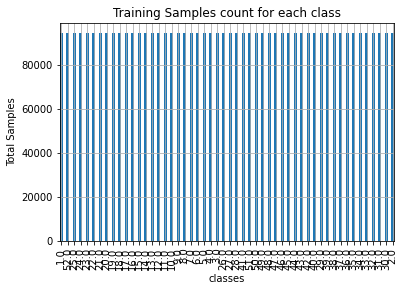

In [15]:
df_Train['Class_label'].value_counts().plot(kind='bar',
                                   title='Training Samples count for each class')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.ylabel('Total Samples')
plt.xlabel('classes')
plt.grid(True)
plt.autoscale(axis='x',tight=True)

In [16]:
df_Test=read_data_Test(file_path_test)
show_basic_dataframe_info(df_Test)
df_Test.head(5)

Number of columns in the dataframe: 11
Number of rows in the dataframe: 2106000



,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label
0,0.03176,0.00247,0.00243,0.00240,0.00244,0.00240,0.00257,0.03562,0.00244,0.00241,1.00000
1,0.03205,0.00248,0.00244,0.00240,0.00245,0.00240,0.00258,0.03567,0.00244,0.00241,1.00000
2,0.03234,0.00248,0.00245,0.00240,0.00246,0.00240,0.00259,0.03569,0.00244,0.00241,1.00000
3,0.03261,0.00249,0.00246,0.00240,0.00246,0.00240,0.00260,0.03570,0.00244,0.00241,1.00000
4,0.03285,0.00249,0.00246,0.00240,0.00246,0.00240,0.00261,0.03566,0.00245,0.00241,1.00000


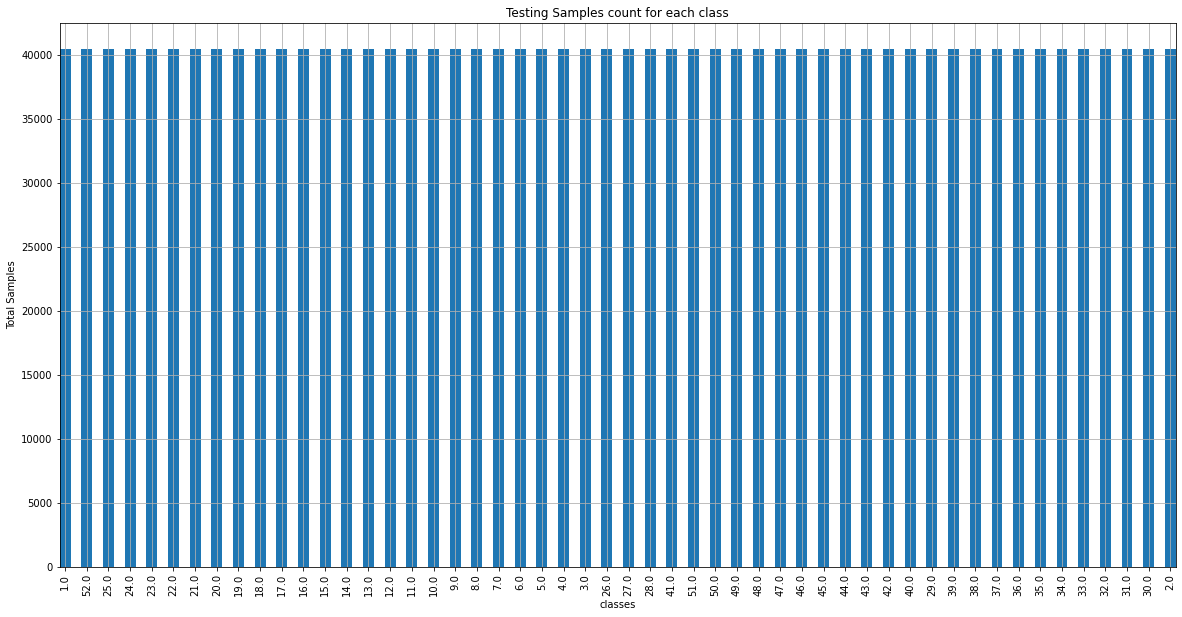

In [17]:
df_Test['Class_label'].value_counts().plot(kind='bar',
                                   title='Testing Samples count for each class')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.ylabel('Total Samples')
plt.xlabel('classes')
plt.grid(True)
plt.autoscale(axis='x',tight=True)

In [18]:
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df_Train[LABEL] = le.fit_transform(df_Train['Class_label'].values.ravel())
# df_Valid[LABEL] = le.fit_transform(df_Valid['Class_label'].values.ravel())
df_Test[LABEL] = le.fit_transform(df_Test['Class_label'].values.ravel())

In [19]:
pd.options.display.float_format = "{:,.5f}".format
df_Train.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label,ActivityEncoded
0,0.00720,0.00242,0.00493,0.00242,0.00245,0.00241,0.00308,0.01634,0.00241,0.00247,1.00000,0
1,0.00836,0.00243,0.00478,0.00242,0.00245,0.00241,0.00312,0.01699,0.00241,0.00247,1.00000,0
2,0.00949,0.00243,0.00464,0.00242,0.00246,0.00241,0.00317,0.01762,0.00241,0.00248,1.00000,0
3,0.01052,0.00243,0.00451,0.00242,0.00246,0.00241,0.00322,0.01822,0.00242,0.00248,1.00000,0
4,0.01142,0.00243,0.00439,0.00242,0.00246,0.00241,0.00327,0.01877,0.00242,0.00248,1.00000,0


In [20]:
scaler = preprocessing.StandardScaler().fit(df_Train.iloc[:,0:N_FEATURES])

In [21]:
df_Train.iloc[:,0:N_FEATURES]=scaler.transform(df_Train.iloc[:,0:N_FEATURES])

In [22]:
pd.options.display.float_format = "{:,.5f}".format
df_Train.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label,ActivityEncoded
0,-0.67597,-0.64137,-0.51809,-0.43726,-0.37267,-0.45614,-0.76033,-0.90886,-0.51943,-0.77849,1.00000,0
1,-0.67360,-0.64137,-0.51846,-0.43725,-0.37263,-0.45613,-0.76027,-0.90759,-0.51942,-0.77848,1.00000,0
2,-0.67130,-0.64136,-0.51882,-0.43725,-0.37260,-0.45613,-0.76019,-0.90634,-0.51942,-0.77847,1.00000,0
3,-0.66919,-0.64136,-0.51915,-0.43724,-0.37256,-0.45613,-0.76012,-0.90516,-0.51942,-0.77846,1.00000,0
4,-0.66736,-0.64135,-0.51946,-0.43724,-0.37252,-0.45612,-0.76004,-0.90409,-0.51942,-0.77845,1.00000,0


In [23]:
pd.options.display.float_format = "{:,.5f}".format
df_Test.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label,ActivityEncoded
0,0.03176,0.00247,0.00243,0.00240,0.00244,0.00240,0.00257,0.03562,0.00244,0.00241,1.00000,0
1,0.03205,0.00248,0.00244,0.00240,0.00245,0.00240,0.00258,0.03567,0.00244,0.00241,1.00000,0
2,0.03234,0.00248,0.00245,0.00240,0.00246,0.00240,0.00259,0.03569,0.00244,0.00241,1.00000,0
3,0.03261,0.00249,0.00246,0.00240,0.00246,0.00240,0.00260,0.03570,0.00244,0.00241,1.00000,0
4,0.03285,0.00249,0.00246,0.00240,0.00246,0.00240,0.00261,0.03566,0.00245,0.00241,1.00000,0


In [24]:
df_Test.iloc[:,0:N_FEATURES]=scaler.transform(df_Test.iloc[:,0:N_FEATURES])

In [25]:
pd.options.display.float_format = "{:,.5f}".format
df_Test.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label,ActivityEncoded
0,-0.62585,-0.64122,-0.52438,-0.43732,-0.37277,-0.45618,-0.76115,-0.87110,-0.51936,-0.77862,1.00000,0
1,-0.62526,-0.64121,-0.52435,-0.43732,-0.37266,-0.45618,-0.76114,-0.87102,-0.51936,-0.77862,1.00000,0
2,-0.62467,-0.64120,-0.52433,-0.43731,-0.37256,-0.45618,-0.76112,-0.87096,-0.51935,-0.77862,1.00000,0
3,-0.62412,-0.64119,-0.52432,-0.43731,-0.37252,-0.45618,-0.76110,-0.87095,-0.51935,-0.77862,1.00000,0
4,-0.62363,-0.64117,-0.52432,-0.43731,-0.37250,-0.45618,-0.76109,-0.87102,-0.51934,-0.77862,1.00000,0


In [26]:
x_train, y_train = create_segments_and_labels(df_Train,TIME_PERIODS,STEP_DISTANCE,N_FEATURES,LABEL)
print('x_train shape: ', x_train.shape)
# print(x_train)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
print('num_time_periods',num_time_periods)
print('num_sensors',num_sensors)
num_classes = le.classes_.size
print('class_list',list(le.classes_))
# input_shape = (num_time_periods,num_sensors)
# print(input_shape)
input_shape = (num_time_periods,num_sensors)
#x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train[0].shape)
print('input_shape:', input_shape)
x_train = x_train.astype('float32')
# x_train = [torch.tensor(arr, dtype=torch.float32) for arr in x_train]
# y_train = y_train.astype('float32')
# print(y_train)
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print(y_train_hot)
# y_train_hot= [torch.tensor(arr, dtype=torch.uint8) for arr in y_train_hot]
print('New y_train shape: ', y_train_hot.shape)

x_train shape:  (9827, 500, 10)
9827 training samples
y_train shape:  (9827,)
num_time_periods 500
num_sensors 10
class_list [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0]
x_train shape: (500, 10)
input_shape: (500, 10)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
New y_train shape:  (9827, 52)


In [27]:
x_test, y_test = create_segments_and_labels(df_Test,TIME_PERIODS,STEP_DISTANCE,N_FEATURES,LABEL)
print('x_test shape: ', x_test.shape)
# print(x_train)
print(x_test.shape[0], 'testing samples')
print('y_test shape: ', y_test.shape)
# Set input_shape / reshape for Keras
#x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test_hot = np_utils.to_categorical(y_test, num_classes)

x_test shape:  (4211, 500, 10)
4211 testing samples
y_test shape:  (4211,)


In [28]:
# n_steps, n_length = 20, 25
# n_steps, n_length= 10, 50
# n_steps, n_length= 16, 32
n_steps, n_length = 5, 5
n_depth,n_view,n_slide = 20,10,1
x_train = x_train.reshape(x_train.shape[0], n_steps, n_length,n_depth,n_view,n_slide)
print('x_train shape: ', x_train.shape)
# x_valid = x_valid.reshape(x_valid.shape[0], n_steps, n_length, n_depth)
# print('x_valid shape: ', x_valid.shape)
x_test = x_test.reshape(x_test.shape[0], n_steps, n_length,n_depth,n_view,n_slide)
print('x_test shape: ', x_test.shape)
n_outputs = y_train_hot.shape[1]
print('n_outputs',n_outputs)

x_train shape:  (9827, 5, 5, 20, 10, 1)
x_test shape:  (4211, 5, 5, 20, 10, 1)
n_outputs 52


In [29]:
input_shape=x_train.shape

In [42]:
def step_decay(epoch):
  initial_lrate = 1e-3
  drop = 0.1
  epochs_drop = 70.0
  lrate = initial_lrate * tf.math.pow(drop,  
          tf.math.floor((1+epoch)/epochs_drop))
  return lrate

In [43]:
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [44]:
verbose, epochs, batch_size = 0, 300, 32

In [45]:
model = Sequential()
model.add(TimeDistributed(Conv3D(filters=64, kernel_size=9, padding='same', kernel_initializer="he_normal",strides=1,kernel_regularizer=l1(1e-04)), \
                           input_shape=(n_steps, n_length,n_depth,n_view,n_slide)))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
# model.add(TimeDistributed(MaxPooling3D(pool_size=2,strides=1)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(Conv3D(filters=64, kernel_size=5,padding="same",kernel_initializer="he_normal",strides=1,kernel_regularizer=l1(1e-04))))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(Dropout(0.2093)))
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=5,padding="same",kernel_initializer="he_normal",strides=2,kernel_regularizer=l1(1e-04))))
# model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
# model.add(TimeDistributed(Activation('tanh')))
# model.add(TimeDistributed(Dropout(0.2093)))
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3,padding="same",kernel_initializer="he_normal",strides=2,kernel_regularizer=l1(1e-04))))
# model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
# model.add(TimeDistributed(Activation('tanh')))
# model.add(TimeDistributed(Dropout(0.2093)))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(Flatten()))
# model.add(Flatten())
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(200,return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(200,return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(SimpleRNN(200,return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(SimpleRNN(200,return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(BatchNormalization(epsilon=1e-05, momentum=0.9, weights=None))
# model.add(Bidirectional(SimpleRNN(200)))
# model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='tanh'))
# model.add(Dense(200, activation='tanh'))
model.add(BatchNormalization(epsilon=1e-05, momentum=0.9, weights=None))
model.add(Dense(n_outputs, activation='softmax'))

In [46]:
adam=optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, amsgrad=False)
checkpoint_filepath = '/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/3DCNN/checkpoint.hdf5'
# model.load_weights(checkpoint_filepath) 
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,verbose=1, monitor='val_accuracy',save_weights_only=True,save_best_only=True)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 5, 5, 20, 10, 64)  46720     
_________________________________________________________________
time_distributed_18 (TimeDis (None, 5, 5, 20, 10, 64)  256       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 5, 5, 20, 10, 64)  0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 5, 5, 20, 10, 64)  512064    
_________________________________________________________________
time_distributed_21 (TimeDis (None, 5, 5, 20, 10, 64)  256       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 5, 5, 20, 10, 64)  0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 5, 5, 20, 10, 64) 

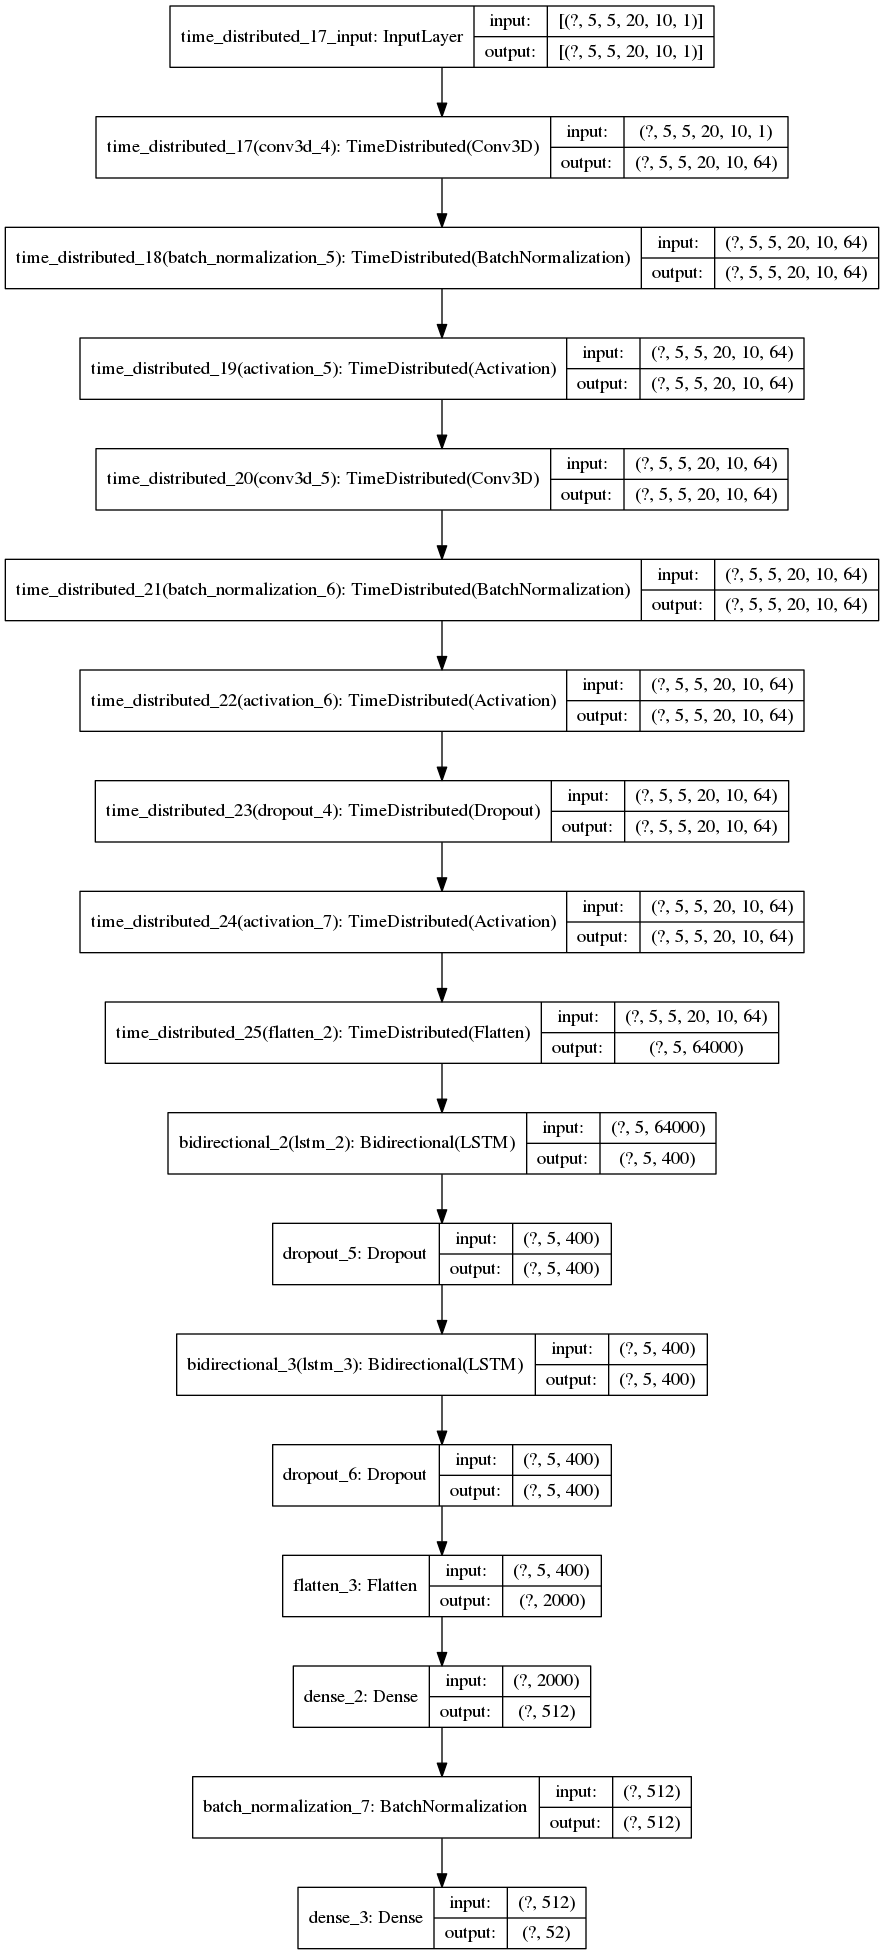

In [47]:
tf.keras.utils.plot_model(model, to_file='/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/3DCNN/Model1.png',show_shapes=True,show_layer_names=True,dpi=96)

In [48]:
# adam=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# sgd=tfa.optimizers.SGDW(weight_decay=0.0001,learning_rate=0.1, momentum=0.9, nesterov=False, name='SGDW')
# sgd=tf.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=False, name='SGD')
#     tf.keras.utils.plot_model(model, to_file='/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/olsson/CNN20X10/Model1.png',show_shapes=True,show_layer_names=True,dpi=96)
csv_logger = CSVLogger('/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/3DCNN/CNN_nina_20X10.csv', append=True, separator=';')
history = model.fit(x_train, y_train_hot, epochs=epochs, batch_size=batch_size, callbacks=[csv_logger,checkpoint_callback,lrate,early],validation_data=(x_test, y_test_hot), verbose=1)
best_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
print('epoch_number',best_index+1)

Epoch 1/300
307/308 [============================>.] - ETA: 0s - loss: 4.5332 - accuracy: 0.0803
Epoch 00001: val_accuracy improved from -inf to 0.14272, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/3DCNN/checkpoint.hdf5
308/308 [==============================] - 32s 104ms/step - loss: 4.5328 - accuracy: 0.0803 - val_loss: 3.8058 - val_accuracy: 0.1427 - lr: 0.0010
Epoch 2/300
307/308 [============================>.] - ETA: 0s - loss: 3.8508 - accuracy: 0.1205
Epoch 00002: val_accuracy improved from 0.14272 to 0.14296, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/3DCNN/checkpoint.hdf5
308/308 [==============================] - 32s 102ms/step - loss: 3.8512 - accuracy: 0.1205 - val_loss: 3.7595 - val_accuracy: 0.1430 - lr: 0.0010
Epoch 3/300
307/308 [============================>.] - ETA: 0s - loss: 3.6840 - accuracy: 0.1469
Epoch 00003: val_accuracy improved from 0.14296 to 0.21658, saving model to /media/naveen/nav/mat_code

Epoch 23/300
307/308 [============================>.] - ETA: 0s - loss: 2.1489 - accuracy: 0.4741
Epoch 00023: val_accuracy improved from 0.56732 to 0.58442, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/3DCNN/checkpoint.hdf5
308/308 [==============================] - 31s 101ms/step - loss: 2.1487 - accuracy: 0.4742 - val_loss: 1.6891 - val_accuracy: 0.5844 - lr: 0.0010
Epoch 24/300
307/308 [============================>.] - ETA: 0s - loss: 2.0496 - accuracy: 0.4948
Epoch 00024: val_accuracy improved from 0.58442 to 0.61102, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/3DCNN/checkpoint.hdf5
308/308 [==============================] - 31s 100ms/step - loss: 2.0494 - accuracy: 0.4949 - val_loss: 1.6522 - val_accuracy: 0.6110 - lr: 0.0010
Epoch 25/300
307/308 [============================>.] - ETA: 0s - loss: 2.0453 - accuracy: 0.4939
Epoch 00025: val_accuracy improved from 0.61102 to 0.62764, saving model to /media/naveen/nav/ma

307/308 [============================>.] - ETA: 0s - loss: 1.3874 - accuracy: 0.6590
Epoch 00046: val_accuracy improved from 0.72833 to 0.73427, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/3DCNN/checkpoint.hdf5
308/308 [==============================] - 31s 102ms/step - loss: 1.3875 - accuracy: 0.6589 - val_loss: 1.1756 - val_accuracy: 0.7343 - lr: 0.0010
Epoch 47/300
307/308 [============================>.] - ETA: 0s - loss: 1.4267 - accuracy: 0.6450
Epoch 00047: val_accuracy did not improve from 0.73427
308/308 [==============================] - 29s 93ms/step - loss: 1.4267 - accuracy: 0.6449 - val_loss: 1.2537 - val_accuracy: 0.7146 - lr: 0.0010
Epoch 48/300
307/308 [============================>.] - ETA: 0s - loss: 1.4015 - accuracy: 0.6602
Epoch 00048: val_accuracy improved from 0.73427 to 0.74828, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/3DCNN/checkpoint.hdf5
308/308 [==============================] - 31s 101ms/st

Epoch 71/300
307/308 [============================>.] - ETA: 0s - loss: 0.8645 - accuracy: 0.8036
Epoch 00071: val_accuracy improved from 0.79791 to 0.80337, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/3DCNN/checkpoint.hdf5
308/308 [==============================] - 31s 100ms/step - loss: 0.8651 - accuracy: 0.8034 - val_loss: 0.9073 - val_accuracy: 0.8034 - lr: 1.0000e-04
Epoch 72/300
307/308 [============================>.] - ETA: 0s - loss: 0.8272 - accuracy: 0.8105
Epoch 00072: val_accuracy improved from 0.80337 to 0.80860, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/3DCNN/checkpoint.hdf5
308/308 [==============================] - 31s 102ms/step - loss: 0.8271 - accuracy: 0.8105 - val_loss: 0.8841 - val_accuracy: 0.8086 - lr: 1.0000e-04
Epoch 73/300
307/308 [============================>.] - ETA: 0s - loss: 0.7882 - accuracy: 0.8226
Epoch 00073: val_accuracy improved from 0.80860 to 0.81002, saving model to /media/navee

307/308 [============================>.] - ETA: 0s - loss: 0.5584 - accuracy: 0.8716
Epoch 00094: val_accuracy did not improve from 0.83021
308/308 [==============================] - 28s 92ms/step - loss: 0.5584 - accuracy: 0.8717 - val_loss: 0.7411 - val_accuracy: 0.8293 - lr: 1.0000e-04
Epoch 95/300
307/308 [============================>.] - ETA: 0s - loss: 0.5471 - accuracy: 0.8733
Epoch 00095: val_accuracy did not improve from 0.83021
308/308 [==============================] - 28s 91ms/step - loss: 0.5473 - accuracy: 0.8731 - val_loss: 0.7390 - val_accuracy: 0.8281 - lr: 1.0000e-04
Epoch 96/300
307/308 [============================>.] - ETA: 0s - loss: 0.5519 - accuracy: 0.8757
Epoch 00096: val_accuracy did not improve from 0.83021
308/308 [==============================] - 28s 90ms/step - loss: 0.5525 - accuracy: 0.8755 - val_loss: 0.7496 - val_accuracy: 0.8231 - lr: 1.0000e-04
Epoch 97/300
307/308 [============================>.] - ETA: 0s - loss: 0.5477 - accuracy: 0.8716
Epoch 

307/308 [============================>.] - ETA: 0s - loss: 0.4722 - accuracy: 0.8914
Epoch 00119: val_accuracy improved from 0.83876 to 0.84161, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/3DCNN/checkpoint.hdf5
308/308 [==============================] - 33s 106ms/step - loss: 0.4726 - accuracy: 0.8913 - val_loss: 0.6879 - val_accuracy: 0.8416 - lr: 1.0000e-04
Epoch 120/300
307/308 [============================>.] - ETA: 0s - loss: 0.4577 - accuracy: 0.8960
Epoch 00120: val_accuracy did not improve from 0.84161
308/308 [==============================] - 30s 96ms/step - loss: 0.4579 - accuracy: 0.8958 - val_loss: 0.7008 - val_accuracy: 0.8388 - lr: 1.0000e-04
Epoch 121/300
307/308 [============================>.] - ETA: 0s - loss: 0.4450 - accuracy: 0.8993
Epoch 00121: val_accuracy did not improve from 0.84161
308/308 [==============================] - 29s 96ms/step - loss: 0.4450 - accuracy: 0.8994 - val_loss: 0.6972 - val_accuracy: 0.8407 - lr: 1.0000e-0

Epoch 145/300
307/308 [============================>.] - ETA: 0s - loss: 0.3766 - accuracy: 0.9158
Epoch 00145: val_accuracy did not improve from 0.84374
308/308 [==============================] - 28s 91ms/step - loss: 0.3765 - accuracy: 0.9158 - val_loss: 0.6666 - val_accuracy: 0.8416 - lr: 1.0000e-05
Epoch 146/300
307/308 [============================>.] - ETA: 0s - loss: 0.3875 - accuracy: 0.9106
Epoch 00146: val_accuracy did not improve from 0.84374
308/308 [==============================] - 28s 89ms/step - loss: 0.3884 - accuracy: 0.9105 - val_loss: 0.6682 - val_accuracy: 0.8421 - lr: 1.0000e-05
Epoch 147/300
307/308 [============================>.] - ETA: 0s - loss: 0.3809 - accuracy: 0.9124
Epoch 00147: val_accuracy did not improve from 0.84374
308/308 [==============================] - 28s 89ms/step - loss: 0.3808 - accuracy: 0.9124 - val_loss: 0.6742 - val_accuracy: 0.8421 - lr: 1.0000e-05
Epoch 148/300
307/308 [============================>.] - ETA: 0s - loss: 0.3701 - accura

Epoch 171/300
307/308 [============================>.] - ETA: 0s - loss: 0.3515 - accuracy: 0.9231
Epoch 00171: val_accuracy did not improve from 0.84778
308/308 [==============================] - 28s 92ms/step - loss: 0.3517 - accuracy: 0.9231 - val_loss: 0.6602 - val_accuracy: 0.8421 - lr: 1.0000e-05
Epoch 172/300
307/308 [============================>.] - ETA: 0s - loss: 0.3575 - accuracy: 0.9203
Epoch 00172: val_accuracy did not improve from 0.84778
308/308 [==============================] - 28s 92ms/step - loss: 0.3583 - accuracy: 0.9201 - val_loss: 0.6592 - val_accuracy: 0.8440 - lr: 1.0000e-05
Epoch 173/300
307/308 [============================>.] - ETA: 0s - loss: 0.3530 - accuracy: 0.9210
Epoch 00173: val_accuracy did not improve from 0.84778
308/308 [==============================] - 29s 94ms/step - loss: 0.3532 - accuracy: 0.9209 - val_loss: 0.6585 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 174/300
307/308 [============================>.] - ETA: 0s - loss: 0.3490 - accura

Epoch 198/300
307/308 [============================>.] - ETA: 0s - loss: 0.3495 - accuracy: 0.9234
Epoch 00198: val_accuracy did not improve from 0.84778
308/308 [==============================] - 28s 92ms/step - loss: 0.3496 - accuracy: 0.9233 - val_loss: 0.6618 - val_accuracy: 0.8445 - lr: 1.0000e-05
Epoch 199/300
307/308 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.9261
Epoch 00199: val_accuracy did not improve from 0.84778
308/308 [==============================] - 29s 94ms/step - loss: 0.3388 - accuracy: 0.9258 - val_loss: 0.6522 - val_accuracy: 0.8449 - lr: 1.0000e-05
Epoch 200/300
307/308 [============================>.] - ETA: 0s - loss: 0.3437 - accuracy: 0.9248
Epoch 00200: val_accuracy did not improve from 0.84778
308/308 [==============================] - 28s 92ms/step - loss: 0.3437 - accuracy: 0.9248 - val_loss: 0.6524 - val_accuracy: 0.8442 - lr: 1.0000e-05
Epoch 201/300
307/308 [============================>.] - ETA: 0s - loss: 0.3460 - accura

Epoch 225/300
307/308 [============================>.] - ETA: 0s - loss: 0.3425 - accuracy: 0.9239
Epoch 00225: val_accuracy did not improve from 0.84802
308/308 [==============================] - 27s 89ms/step - loss: 0.3432 - accuracy: 0.9237 - val_loss: 0.6497 - val_accuracy: 0.8447 - lr: 1.0000e-06
Epoch 226/300
307/308 [============================>.] - ETA: 0s - loss: 0.3466 - accuracy: 0.9244
Epoch 00226: val_accuracy did not improve from 0.84802
308/308 [==============================] - 28s 90ms/step - loss: 0.3467 - accuracy: 0.9243 - val_loss: 0.6514 - val_accuracy: 0.8447 - lr: 1.0000e-06
Epoch 227/300
307/308 [============================>.] - ETA: 0s - loss: 0.3373 - accuracy: 0.9257
Epoch 00227: val_accuracy did not improve from 0.84802
308/308 [==============================] - 28s 89ms/step - loss: 0.3374 - accuracy: 0.9256 - val_loss: 0.6489 - val_accuracy: 0.8464 - lr: 1.0000e-06
Epoch 228/300
307/308 [============================>.] - ETA: 0s - loss: 0.3374 - accura

KeyboardInterrupt: 

In [ ]:
print('train accuracy and validation accuracy', history.history['accuracy'][best_index], history.history['val_accuracy'][best_index])
model.load_weights(checkpoint_filepath) 
_, testaccuracy = model.evaluate(x_test, y_test_hot, batch_size=batch_size, verbose=1)
print('test_accuracy',testaccuracy)
# test_acc.append(testaccuracy)

In [ ]:
model.save('/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/3DCNN/CNN_LSTM_nina_5X97')

In [ ]:
for i in history.history:
    print("history",i)
# facecolor='black'
DB1a=plt.figure(figsize=(10, 8),edgecolor='black')
# ax=figDB4.add_axes(("left", "bottom", "width", "height"))
ax= DB1a.add_axes((1,1,1,1))
ax.spines["top"].set_position(("outward", 0))
ax.spines["bottom"].set_position(("data", 0))
ax.spines["left"].set_position(("axes", 0))
ax.spines["right"].set_position(("outward", 0))

ax.spines["top"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["bottom"].set_color("black")

# ax.spines["left"].set_bounds(-.5, .5)
# ax.spines["right"].set_linestyle("--")
# ax.spines["bottom"].set_linewidth(6)
# ax.spines["bottom"].set_capstyle("round")

# plt2.rcParams['figure.facecolor'] = 'white'
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')

# plt2.ylim(0)
# plt2.rcParams['figure.facecolor'] = 'white'

# ax = fig.add_axes((left, bottom, width, height))
ax.set(facecolor="white")
# ax.patch.set_alpha(1.0)
plt.ylim(0)
plt.legend()
plt.show()

In [ ]:
for i in history.history:
    print("history",i)
# facecolor='black'
ax= figDB1.add_axes((1,1,1,1))
ax.spines["top"].set_position(("outward", 0))
ax.spines["bottom"].set_position(("data", 0))
ax.spines["left"].set_position(("axes", 0))
ax.spines["right"].set_position(("outward", 0))

ax.spines["top"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["bottom"].set_color("black") 

figDB1=plt.figure(figsize=(10, 8),edgecolor='black')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

# SMALL_SIZE = 12
# MEDIUM_SIZE = 14
# BIGGER_SIZE = 18

# figBPR.suptitle('test title', fontsize=20)
#plt.rc('xlabel', fontsize=14, weight = 'bold')
#plt.rc('ylabel', fontsize=14, weight = 'bold')

# plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
# plt.rc('axes', labelsize=MEDIUM_SIZE )     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE, weight = 'bold')    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE )  # fontsize of the figure title

# ax=figDB1.add_axes(("left", "bottom", "width", "height"))
# ax= figDB1.add_axes((1,1,1,1))
# ax.spines["top"].set_position(("outward", 0))
# ax.spines["bottom"].set_position(("data", 0))
# ax.spines["left"].set_position(("axes", 0))
# ax.spines["right"].set_position(("outward", 0))

# ax.spines["top"].set_color("black")
# ax.spines["left"].set_color("black")
# ax.spines["right"].set_color("black")
# ax.spines["bottom"].set_color("black")

# ax.spines["left"].set_bounds(-.5, .5)
# ax.spines["right"].set_linestyle("--")
ax.spines["top"].set_linewidth(3)
ax.spines["top"].set_linestyle("-")
ax.spines["bottom"].set_linewidth(3)
ax.spines["bottom"].set_linestyle("-")
ax.spines["left"].set_linewidth(3)
ax.spines["left"].set_linestyle("-")
ax.spines["right"].set_linewidth(3)
ax.spines["right"].set_linestyle("-")
# ax.spines["bottom"].set_capstyle("round")

# plt2.rcParams['figure.facecolor'] = 'white'
plt.plot(history.history['loss'], 'r-', linewidth=3, label='Loss on training data')
plt.plot(history.history['val_loss'], 'b-', linewidth=3, label='Loss on validation data')
plt.title('Loss curve for NinaPro DB1',fontsize=18, weight = 'bold')

plt.ylabel('Loss',fontsize=16, weight = 'bold')
plt.xlabel('no of training epochs',fontsize=16, weight = 'bold')
# plt2.ylim(0)
# plt2.rcParams['figure.facecolor'] = 'white'

# ax = fig.add_axes((left, bottom, width, height))
ax.set(facecolor="white")
# ax.patch.set_alpha(1.0)
plt.ylim(0)
plt.legend()
plt.show()

In [ ]:
# figDB1.savefig('/media/naveen/nav/plots/NinaPro_DB1_25X20.eps',transparent=False)
# figDB1.savefig('/media/naveen/nav/plots/NinaPro_DB1_25X20.pdf',transparent=False)

In [ ]:
model.load_weights(checkpoint_filepath) 
_, testaccuracy = model.evaluate(x_test, y_test_hot, batch_size=batch_size, verbose=1)
print('test_accuracy',testaccuracy)

In [ ]:
y_pred_train = model.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
#max_y_train = np.argmax(y_train, axis=1)
show_confusion_matrix(y_train, max_y_pred_train)
print(classification_report(y_train, max_y_pred_train))

In [ ]:
y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test_hot, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))